In [3]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

eval_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
import os
import os.path
from torch.utils.data import Dataset
from PIL import Image

class CatsAndDogs(Dataset):
    def __init__(self, indices, labels, dir, transform=None):
        self.indices = indices
        self.labels = labels
        self.dir = dir
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        
        if 'training_set' in self.dir:
            label = self.labels['train'][index]
            image_path = os.path.join(self.dir, f'cats/cat.{index+1}.jpg') if index < 4000 else os.path.join(self.dir, f'dogs/dog.{index-3999}.jpg')
        else:
            label = self.labels['test'][index]
            image_path = os.path.join(self.dir, f'cats/cat.{index+4001}.jpg') if index < 1000 else os.path.join(self.dir, f'dogs/dog.{index+3001}.jpg')
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label
        


In [11]:
train_labels = [0 for _ in range(4000)]
train_labels.extend([1 for _ in range(4000)])

test_labels = [0 for _ in range(1000)]
test_labels.extend([1 for _ in range(10000)])
labels = {'train': train_labels,
          'test': test_labels} #0=cat, 1=dog

train_ids = [i for i in range(8000)] #first 4000 cats, then 4000 dogs
test_ids = [i for i in range(2000)] #first 1000 cats, then 1000 dogs

train_dir = './data/training_set'
test_dir = './data/test_set'

# first no data augmentation

In [12]:
import sklearn.model_selection as ms

trainset = CatsAndDogs(train_ids, labels, train_dir, transform=train_transform)

train_indexes, val_indexes = ms.train_test_split(list(range(len(trainset))), train_size=0.9, shuffle=True, random_state=42)

validation_set = torch.utils.data.Subset(trainset, val_indexes)
trainset = torch.utils.data.Subset(trainset, train_indexes)
testset = CatsAndDogs(test_ids, labels, test_dir, transform=eval_tranform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valloader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

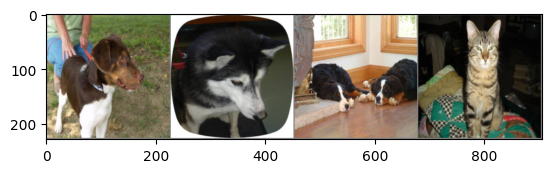

1	1	1	0	


In [77]:
#visualize some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    image = image.detach().cpu()               # togli grad e porta su CPU
    image = (image + 1)/2
    npimage = image.numpy()
    npimage = np.transpose(npimage, (1, 2, 0))
    plt.imshow(npimage)
    plt.show()

dataiter = iter(trainloader)
images, targets = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join(f'{targets[i]}\t' for i in range(BATCH_SIZE)))

# load pre-trained alexnet

In [89]:
net = alexnet(pretrained=True)


net.classifier[6] = nn.Linear(4096, 2) #0=cat, 1=dog

parameters_to_optimize = net.classifier[6].parameters()

criterion = nn.CrossEntropyLoss()


c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Utente/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:11<00:00, 20.4MB/s] 


# define training function

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer):
    patience = 5
    validation_losses_epochs = [] #contains losses after each batch
    train_losses_epochs = [] #same

    train_accuracy_epochs = []
    validation_accuracy_epochs = []

    model.to(device)

    best_val_acc = 0
    epochs_without_improvement = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_corrects = 0
        total_loss = 0
        num_samples = 0
        print(f'Starting training for epoch {epoch}')


        for i, batch in enumerate(train_loader):

            bs = batch[0].shape[0]
            num_samples += bs
            images, targets = batch
            images , targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            preds= model(images) 
            #preds e un tensore di logits, quindi per ogni immagine, c'e un tensore 1d con i logit, uno per classe
            # --> il primo indice, cioe l'indice del'intero vettore logits, indica l'immagine a cui il vettore si riferisce
            # --> l'indice dentro i logits corrisponde al numero del target rispetto al quale e stato calcolato quel logit
            #in tutto cio lo shape ha sempre (batch_size,) all'inizio

            _, targets_pred = torch.max(preds, 1)

            train_corrects += torch.sum(targets == targets_pred).item()

            loss = criterion(preds, targets)

            loss.backward()

            optimizer.step()

            
            total_loss += loss.item() * bs
        
        train_losses_epochs.append(total_loss/num_samples)
        
        print(f'Train loss for epoch {epoch}: {total_loss/num_samples:.4f}')
        
        train_accuracy_epochs.append(1.0*train_corrects/float(num_samples))
        


        model.eval()
        val_corrects = 0
        total_loss=0
        num_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images, targets = batch
                images, targets = images.to(device), targets.to(device) 

                bs = batch[0].shape[0]
                num_samples+=bs
                preds = model(images)

                _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
                #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
                #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
                #in tutto cio lo shape ha sempre (batch_size,) all'inizio

                val_corrects += torch.sum(targets == targets_pred).item()

                loss = criterion(preds, targets)

                total_loss += loss.item() * bs

            val_acc = 1.0*val_corrects/float(num_samples)
            validation_accuracy_epochs.append(val_acc)
            validation_losses_epochs.append(total_loss/num_samples)

            if (val_acc > best_val_acc):
                best_val_acc = val_acc
                epochs_without_improvement = 0
                torch.save(model.state_dict(), f'best_model.pth')
            
            else:
                epochs_without_improvement +=1
            
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}. Best val acc: {best_val_acc:.4f}')
                break
            

            

    return validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs

# experiment 1 --> freezing

c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:523: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Starting training for epoch 0, LR = [0.001]
Train loss for epoch 0: 0.2868
Starting training for epoch 1, LR = [0.001]
Train loss for epoch 1: 0.1594
Starting training for epoch 2, LR = [0.001]
Train loss for epoch 2: 0.1500
Starting training for epoch 3, LR = [0.001]
Train loss for epoch 3: 0.1457
Starting training for epoch 4, LR = [0.001]
Train loss for epoch 4: 0.1463
Starting training for epoch 5, LR = [0.001]
Train loss for epoch 5: 0.1451
Starting training for epoch 6, LR = [0.001]
Train loss for epoch 6: 0.1327
Starting training for epoch 7, LR = [0.001]
Train loss for epoch 7: 0.1287
Starting training for epoch 8, LR = [0.001]
Train loss for epoch 8: 0.1294
Starting training for epoch 9, LR = [0.001]
Train loss for epoch 9: 0.1255
Starting training for epoch 10, LR = [0.001]
Train loss for epoch 10: 0.1210
Starting training for epoch 11, LR = [0.001]
Train loss for epoch 11: 0.1204
Starting training for epoch 12, LR = [0.001]
Train loss for epoch 12: 0.1198
Starting training f

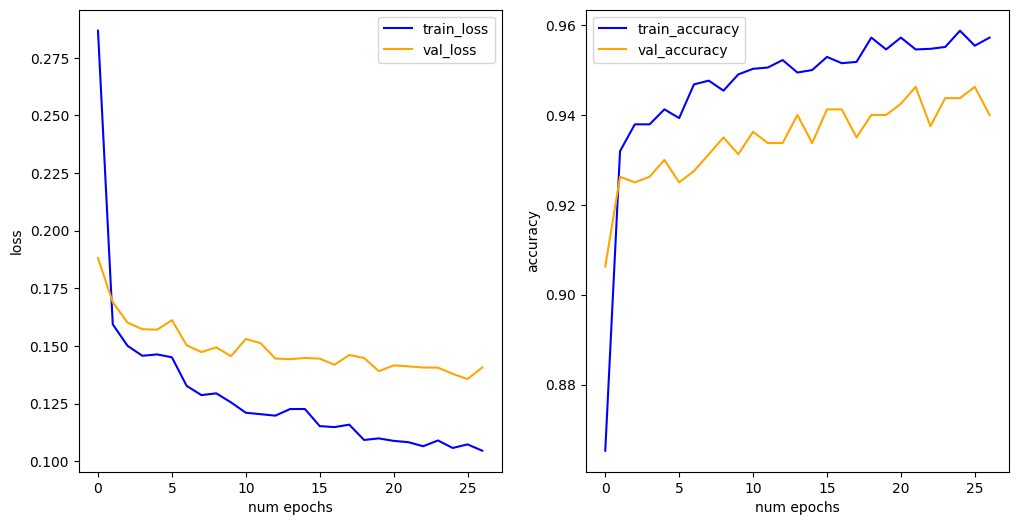

In [ ]:
for param in net.parameters():
    param.requires_grad = False

for param in net.classifier[6].parameters():
    param.requires_grad=True

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_epochs, c='blue', label='train_loss')
ax[0].plot(validation_losses_epochs, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()


# evaluation

In [91]:
total_loss=0
num_samples = 0
val_corrects = 0
net.load_state_dict(torch.load('best_model.pth'))

net.to(device)
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST ACCURACY: {acc_test}')

TEST ACCURACY: 95.3


# experiment 2 --> FINE-TUNING

In [93]:
net = alexnet(pretrained=True)

net

c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Starting training for epoch 0
Train loss for epoch 0: 0.2910
Starting training for epoch 1
Train loss for epoch 1: 0.1679
Starting training for epoch 2
Train loss for epoch 2: 0.1505
Starting training for epoch 3
Train loss for epoch 3: 0.1380
Starting training for epoch 4
Train loss for epoch 4: 0.1357
Starting training for epoch 5
Train loss for epoch 5: 0.1321
Starting training for epoch 6
Train loss for epoch 6: 0.1239
Starting training for epoch 7
Train loss for epoch 7: 0.1229
Starting training for epoch 8
Train loss for epoch 8: 0.1223
Early stopping at epoch 8. Best val acc: 0.9400


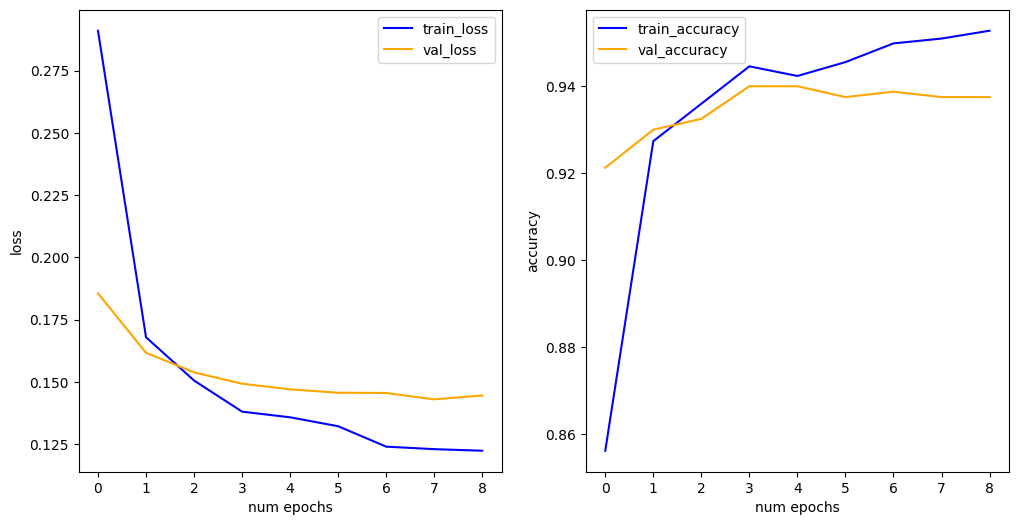

In [ ]:
net.classifier[6] = nn.Linear(4096, 2) #0=cat, 1=dog

#FREEZE PARZIALE
for param in net.features[0].parameters():
    param.requires_grad = False

for param in net.features[3].parameters():
    param.requires_grad = False

#FINE-TUNING
parameters_to_optimize = net.parameters()

optimizer = optim.SGD([
    {'params': net.features[6].parameters(), 'lr': 1e-5},
    {'params': net.features[8].parameters(), 'lr': 3e-5},
    {'params': net.features[10].parameters(), 'lr': 5e-5},
    {'params': net.classifier[1].parameters(), 'lr': 1e-4},
    {'params': net.classifier[4].parameters(), 'lr': 5e-4},
    {'params': net.classifier[6].parameters(), 'lr': 1e-3}
    ], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


criterion = nn.CrossEntropyLoss()

validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_epochs, c='blue', label='train_loss')
ax[0].plot(validation_losses_epochs, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

# evaluation

In [95]:
total_loss=0
num_samples = 0
val_corrects = 0
net.load_state_dict(torch.load('best_model.pth'))

net.to(device)
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST ACCURACY: {acc_test}')

TEST ACCURACY: 94.95


# experiment 3 --> fine-tuning only few parts

In [ ]:
net = alexnet(pretrained=True)

net.classifier[6] = nn.Linear(4096, 2) #0=cat, 1=dog

#FREEZE PARZIALE
for param in net.features[0].parameters():
    param.requires_grad = False

for param in net.features[3].parameters():
    param.requires_grad = False

for param in net.features[8].parameters():
    param.requires_grad = False

for param in net.features[10].parameters():
    param.requires_grad = False



#FINE-TUNING
optimizer = optim.SGD([
    {'params': net.classifier[1].parameters(), 'lr': 1e-4},
    {'params': net.classifier[4].parameters(), 'lr': 5e-4},
    {'params': net.classifier[6].parameters(), 'lr': 1e-3}
    ], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


criterion = nn.CrossEntropyLoss()

validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer)


c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for epoch 0
Train loss for epoch 0: 0.2815
Starting training for epoch 1
Train loss for epoch 1: 0.1656
Starting training for epoch 2
Train loss for epoch 2: 0.1480
Starting training for epoch 3
Train loss for epoch 3: 0.1386
Starting training for epoch 4
Train loss for epoch 4: 0.1403
Starting training for epoch 5
Train loss for epoch 5: 0.1318
Starting training for epoch 6
Train loss for epoch 6: 0.1301
Starting training for epoch 7
Train loss for epoch 7: 0.1267
Starting training for epoch 8
Train loss for epoch 8: 0.1241
Starting training for epoch 9
Train loss for epoch 9: 0.1203
Starting training for epoch 10
Train loss for epoch 10: 0.1184
Starting training for epoch 11
Train loss for epoch 11: 0.1139
Starting training for epoch 12
Train loss for epoch 12: 0.1132
Starting training for epoch 13
Train loss for epoch 13: 0.1135
Starting training for epoch 14
Train loss for epoch 14: 0.1149
Starting training for epoch 15
Train loss for epoch 15: 0.1138
Starting tra

NameError: name 'plt' is not defined

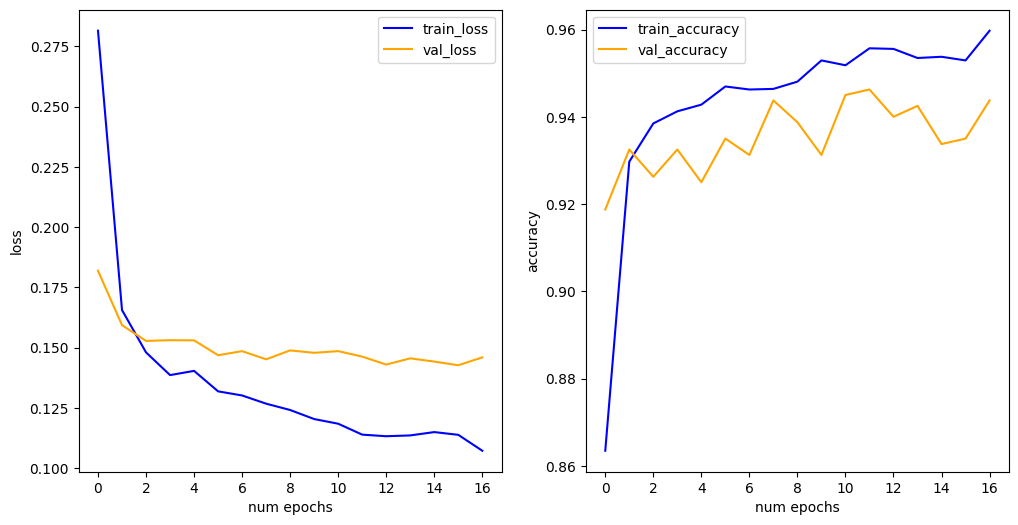

In [14]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_epochs, c='blue', label='train_loss')
ax[0].plot(validation_losses_epochs, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

In [15]:
total_loss=0
num_samples = 0
val_corrects = 0
net.load_state_dict(torch.load('best_model.pth'))

net.to(device)
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST ACCURACY: {acc_test}')

TEST ACCURACY: 95.2


# experiment 4 --> with and without warm up stage

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    patience = 5
    validation_losses_epochs = [] #contains losses after each batch
    train_losses_epochs = [] #same

    train_accuracy_epochs = []
    validation_accuracy_epochs = []

    model.to(device)

    best_val_acc = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_corrects = 0
        total_loss = 0
        num_samples = 0
        print(f'Starting training for epoch {epoch}')


        for i, batch in enumerate(train_loader):

            bs = batch[0].shape[0]
            num_samples += bs
            images, targets = batch
            images , targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            preds= model(images) 
            #preds e un tensore di logits, quindi per ogni immagine, c'e un tensore 1d con i logit, uno per classe
            # --> il primo indice, cioe l'indice del'intero vettore logits, indica l'immagine a cui il vettore si riferisce
            # --> l'indice dentro i logits corrisponde al numero del target rispetto al quale e stato calcolato quel logit
            #in tutto cio lo shape ha sempre (batch_size,) all'inizio

            _, targets_pred = torch.max(preds, 1)

            train_corrects += torch.sum(targets == targets_pred).item()

            loss = criterion(preds, targets)

            loss.backward()

            optimizer.step()

            
            total_loss += loss.item() * bs
        
        train_losses_epochs.append(total_loss/num_samples)
        
        print(f'Train loss for epoch {epoch}: {total_loss/num_samples:.4f}')
        
        train_accuracy_epochs.append(1.0*train_corrects/float(num_samples))
        


        model.eval()
        val_corrects = 0
        total_loss=0
        num_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images, targets = batch
                images, targets = images.to(device), targets.to(device) 

                bs = batch[0].shape[0]
                num_samples+=bs
                preds = model(images)

                _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
                #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
                #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
                #in tutto cio lo shape ha sempre (batch_size,) all'inizio

                val_corrects += torch.sum(targets == targets_pred).item()

                loss = criterion(preds, targets)

                total_loss += loss.item() * bs

            val_acc = 1.0*val_corrects/float(num_samples)
            validation_accuracy_epochs.append(val_acc)
            validation_losses_epochs.append(total_loss/num_samples)

            if (val_acc > best_val_acc):
                best_val_acc = val_acc
                epochs_without_improvement = 0
                torch.save(model.state_dict(), f'best_model.pth')
            
            else:
                epochs_without_improvement +=1
            
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}. Best val acc: {best_val_acc:.4f}')
                break
            

            

    return validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs

c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for epoch 0
Train loss for epoch 0: 0.2893
Starting training for epoch 1
Train loss for epoch 1: 0.1696
Starting training for epoch 2
Train loss for epoch 2: 0.1531
Starting training for epoch 3
Train loss for epoch 3: 0.1461
Starting training for epoch 4
Train loss for epoch 4: 0.1426
Starting training for epoch 0
Train loss for epoch 0: 0.1488
Starting training for epoch 1
Train loss for epoch 1: 0.1394
Starting training for epoch 2
Train loss for epoch 2: 0.1399
Starting training for epoch 3
Train loss for epoch 3: 0.1289
Starting training for epoch 4
Train loss for epoch 4: 0.1257
Starting training for epoch 5
Train loss for epoch 5: 0.1216
Starting training for epoch 6
Train loss for epoch 6: 0.1169
Starting training for epoch 7
Train loss for epoch 7: 0.1145
Starting training for epoch 8
Train loss for epoch 8: 0.1156
Starting training for epoch 9
Train loss for epoch 9: 0.1134
Starting training for epoch 10
Train loss for epoch 10: 0.1105
Starting training for 

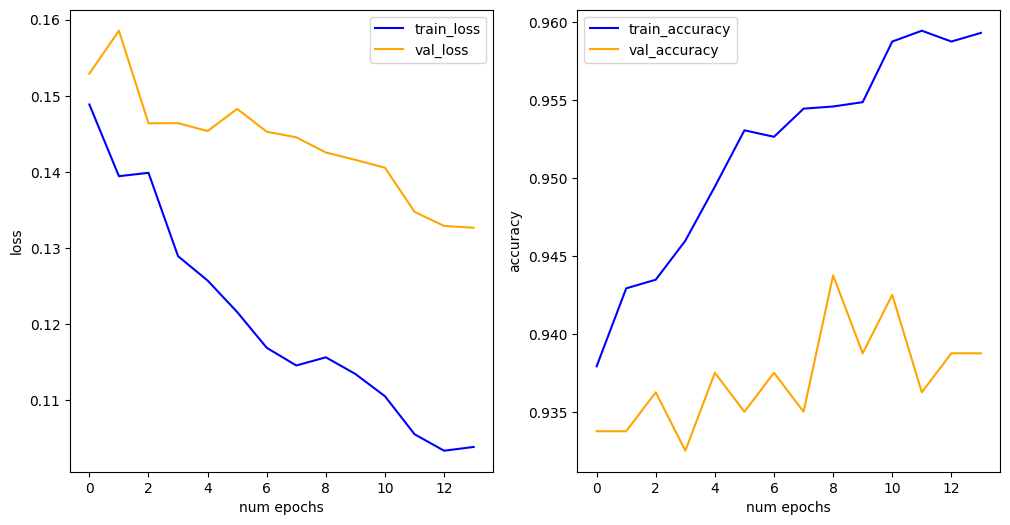

In [17]:
#fine tune with warm-up stage (freezing) before

net = alexnet(pretrained=True)

net.classifier[6] = nn.Linear(4096, 2) #0=cat, 1=dog

for param in net.parameters():
    param.requires_grad = False

for param in net.classifier[6].parameters():
    param.requires_grad=True

parameters_to_optimize = net.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#train with freezing for 5 epochs
validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, epochs=5)

net.load_state_dict(torch.load('best_model.pth'))

#FINE-TUNING
parameters_to_optimize = net.parameters()

for param in net.parameters():
    param.requires_grad = True

optimizer = optim.SGD([
    {'params': net.features[6].parameters(), 'lr': 1e-5},
    {'params': net.features[8].parameters(), 'lr': 3e-5},
    {'params': net.features[10].parameters(), 'lr': 5e-5},
    {'params': net.classifier[1].parameters(), 'lr': 1e-4},
    {'params': net.classifier[4].parameters(), 'lr': 5e-4},
    {'params': net.classifier[6].parameters(), 'lr': 1e-3}
    ], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#train for longer with fine-tuning
validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, epochs=25)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_epochs, c='blue', label='train_loss')
ax[0].plot(validation_losses_epochs, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()


In [18]:
total_loss=0
num_samples = 0
val_corrects = 0
net.load_state_dict(torch.load('best_model.pth'))

net.to(device)
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST ACCURACY: {acc_test}')

TEST ACCURACY: 95.05


# experiment 5 --> data augmentation
starting from the 'fine-tuning only few part' model

In [23]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

eval_tranform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),        
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [24]:
import sklearn.model_selection as ms

trainset = CatsAndDogs(train_ids, labels, train_dir, transform=train_transform)

train_indexes, val_indexes = ms.train_test_split(list(range(len(trainset))), train_size=0.9, shuffle=True, random_state=42)

validation_set = torch.utils.data.Subset(trainset, val_indexes)
trainset = torch.utils.data.Subset(trainset, train_indexes)
testset = CatsAndDogs(test_ids, labels, test_dir, transform=eval_tranform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valloader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Starting training for epoch 0
Train loss for epoch 0: 0.4310
Starting training for epoch 1
Train loss for epoch 1: 0.3157
Starting training for epoch 2
Train loss for epoch 2: 0.3104
Starting training for epoch 3
Train loss for epoch 3: 0.2981
Starting training for epoch 4
Train loss for epoch 4: 0.3022
Starting training for epoch 5
Train loss for epoch 5: 0.2895
Starting training for epoch 6
Train loss for epoch 6: 0.2831
Starting training for epoch 7
Train loss for epoch 7: 0.2911
Starting training for epoch 8
Train loss for epoch 8: 0.2870
Starting training for epoch 9
Train loss for epoch 9: 0.2843
Starting training for epoch 10
Train loss for epoch 10: 0.2898
Early stopping at epoch 10. Best val acc: 0.8838


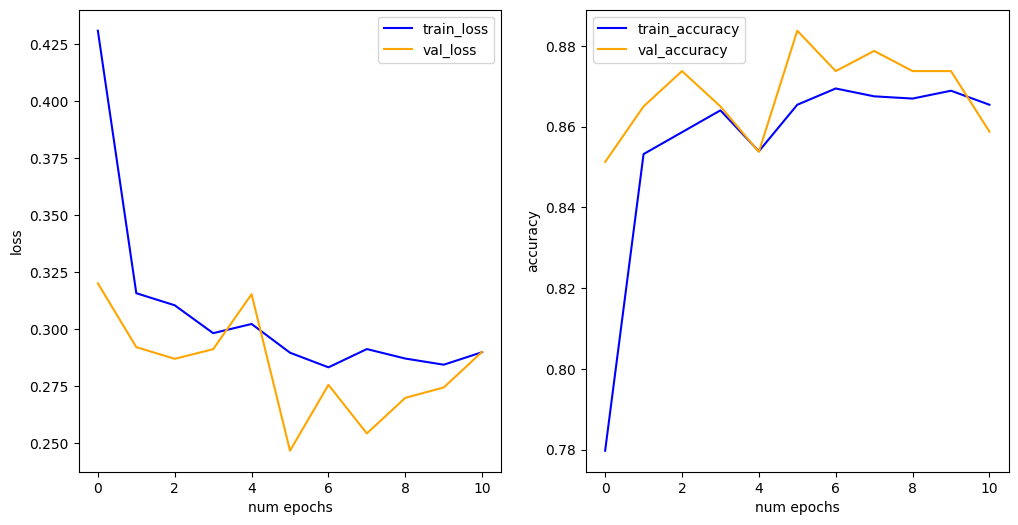

In [25]:
net = alexnet(pretrained=True)

net.classifier[6] = nn.Linear(4096, 2) #0=cat, 1=dog

#FREEZE PARZIALE
for param in net.features[0].parameters():
    param.requires_grad = False

for param in net.features[3].parameters():
    param.requires_grad = False

for param in net.features[8].parameters():
    param.requires_grad = False

for param in net.features[10].parameters():
    param.requires_grad = False



#FINE-TUNING
optimizer = optim.SGD([
    {'params': net.classifier[1].parameters(), 'lr': 1e-4},
    {'params': net.classifier[4].parameters(), 'lr': 5e-4},
    {'params': net.classifier[6].parameters(), 'lr': 1e-3}
    ], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


criterion = nn.CrossEntropyLoss()

validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, epochs=NUM_EPOCHS)

import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_epochs, c='blue', label='train_loss')
ax[0].plot(validation_losses_epochs, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

In [26]:
total_loss=0
num_samples = 0
val_corrects = 0
net.load_state_dict(torch.load('best_model.pth'))

net.to(device)
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST ACCURACY: {acc_test}')

TEST ACCURACY: 95.35


# considerations

1. What is the accuracy when using the pre-trained network as feature extraction (all base layers
frozen) and training only the added top layer (warm up)? **95.3**

2. What is the accuracy after fine-tuning the transferred layers? **94.95**

3. How does the accuracy change if we fine-tune only part of the layers? **95.2**

4. How does the performance change with and without a warm up stage? 
    without **94.95** or **95.2** (from points 2. and 3.)
    with **95.05**

5. How does the validation performance change without data augmentation? better generalization --> **95.35**


